In [ ]:
!pip install rasterio

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import os
from rasterio.plot import show

In [ ]:
import sqlite3
import pandas as pd

In [ ]:
conn = sqlite3.connect("compiled_gcbm_output.db")

### NPP, NEP and NBP

In [ ]:
query = f"""
        SELECT years.year, COALESCE(SUM(i.flux_tc), 0) / 1e6 AS NPP_mt, COALESCE(SUM(j.flux_tc), 0) / 1e6 AS NEP_mt, COALESCE(SUM(k.flux_tc), 0) / 1e6 AS NBP_mt
        FROM (SELECT DISTINCT year FROM v_age_indicators ORDER BY year) AS years
        LEFT JOIN v_stock_change_indicators_density i
            ON years.year = i.year
        LEFT JOIN v_stock_change_indicators_density j
            ON years.year = j.year
        LEFT JOIN v_stock_change_indicators_density k
            ON years.year = k.year
        WHERE i.indicator = 'NPP' and j.indicator = 'NEP' and k.indicator='NBP'
            AND (years.year BETWEEN 1900 AND 2050)
        GROUP BY years.year
        ORDER BY years.year
        """

In [ ]:
df = pd.read_sql_query(query, conn)
df.head()

,year,NPP_mt,NEP_mt,NBP_mt
0,2010,242.051980,106.773284,106.773284
1,2011,49.449230,-72.334325,-72.334325
2,2012,38.588949,-60.693467,-60.693467
3,2013,42.914482,-43.052486,-43.052486
4,2014,45.171823,-31.517218,-31.517218


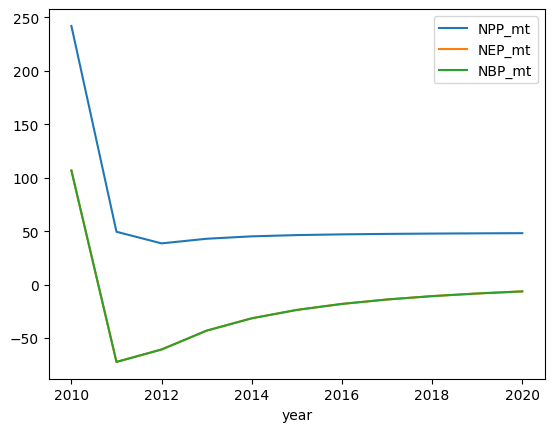

In [ ]:
ax = df.plot.line("year") # because there was no disturbance layer, NEP = NBP

### Spatial time lapse of NEP & NBP

In [ ]:
import matplotlib as mpl
import numpy as np
from matplotlib import cm, colors

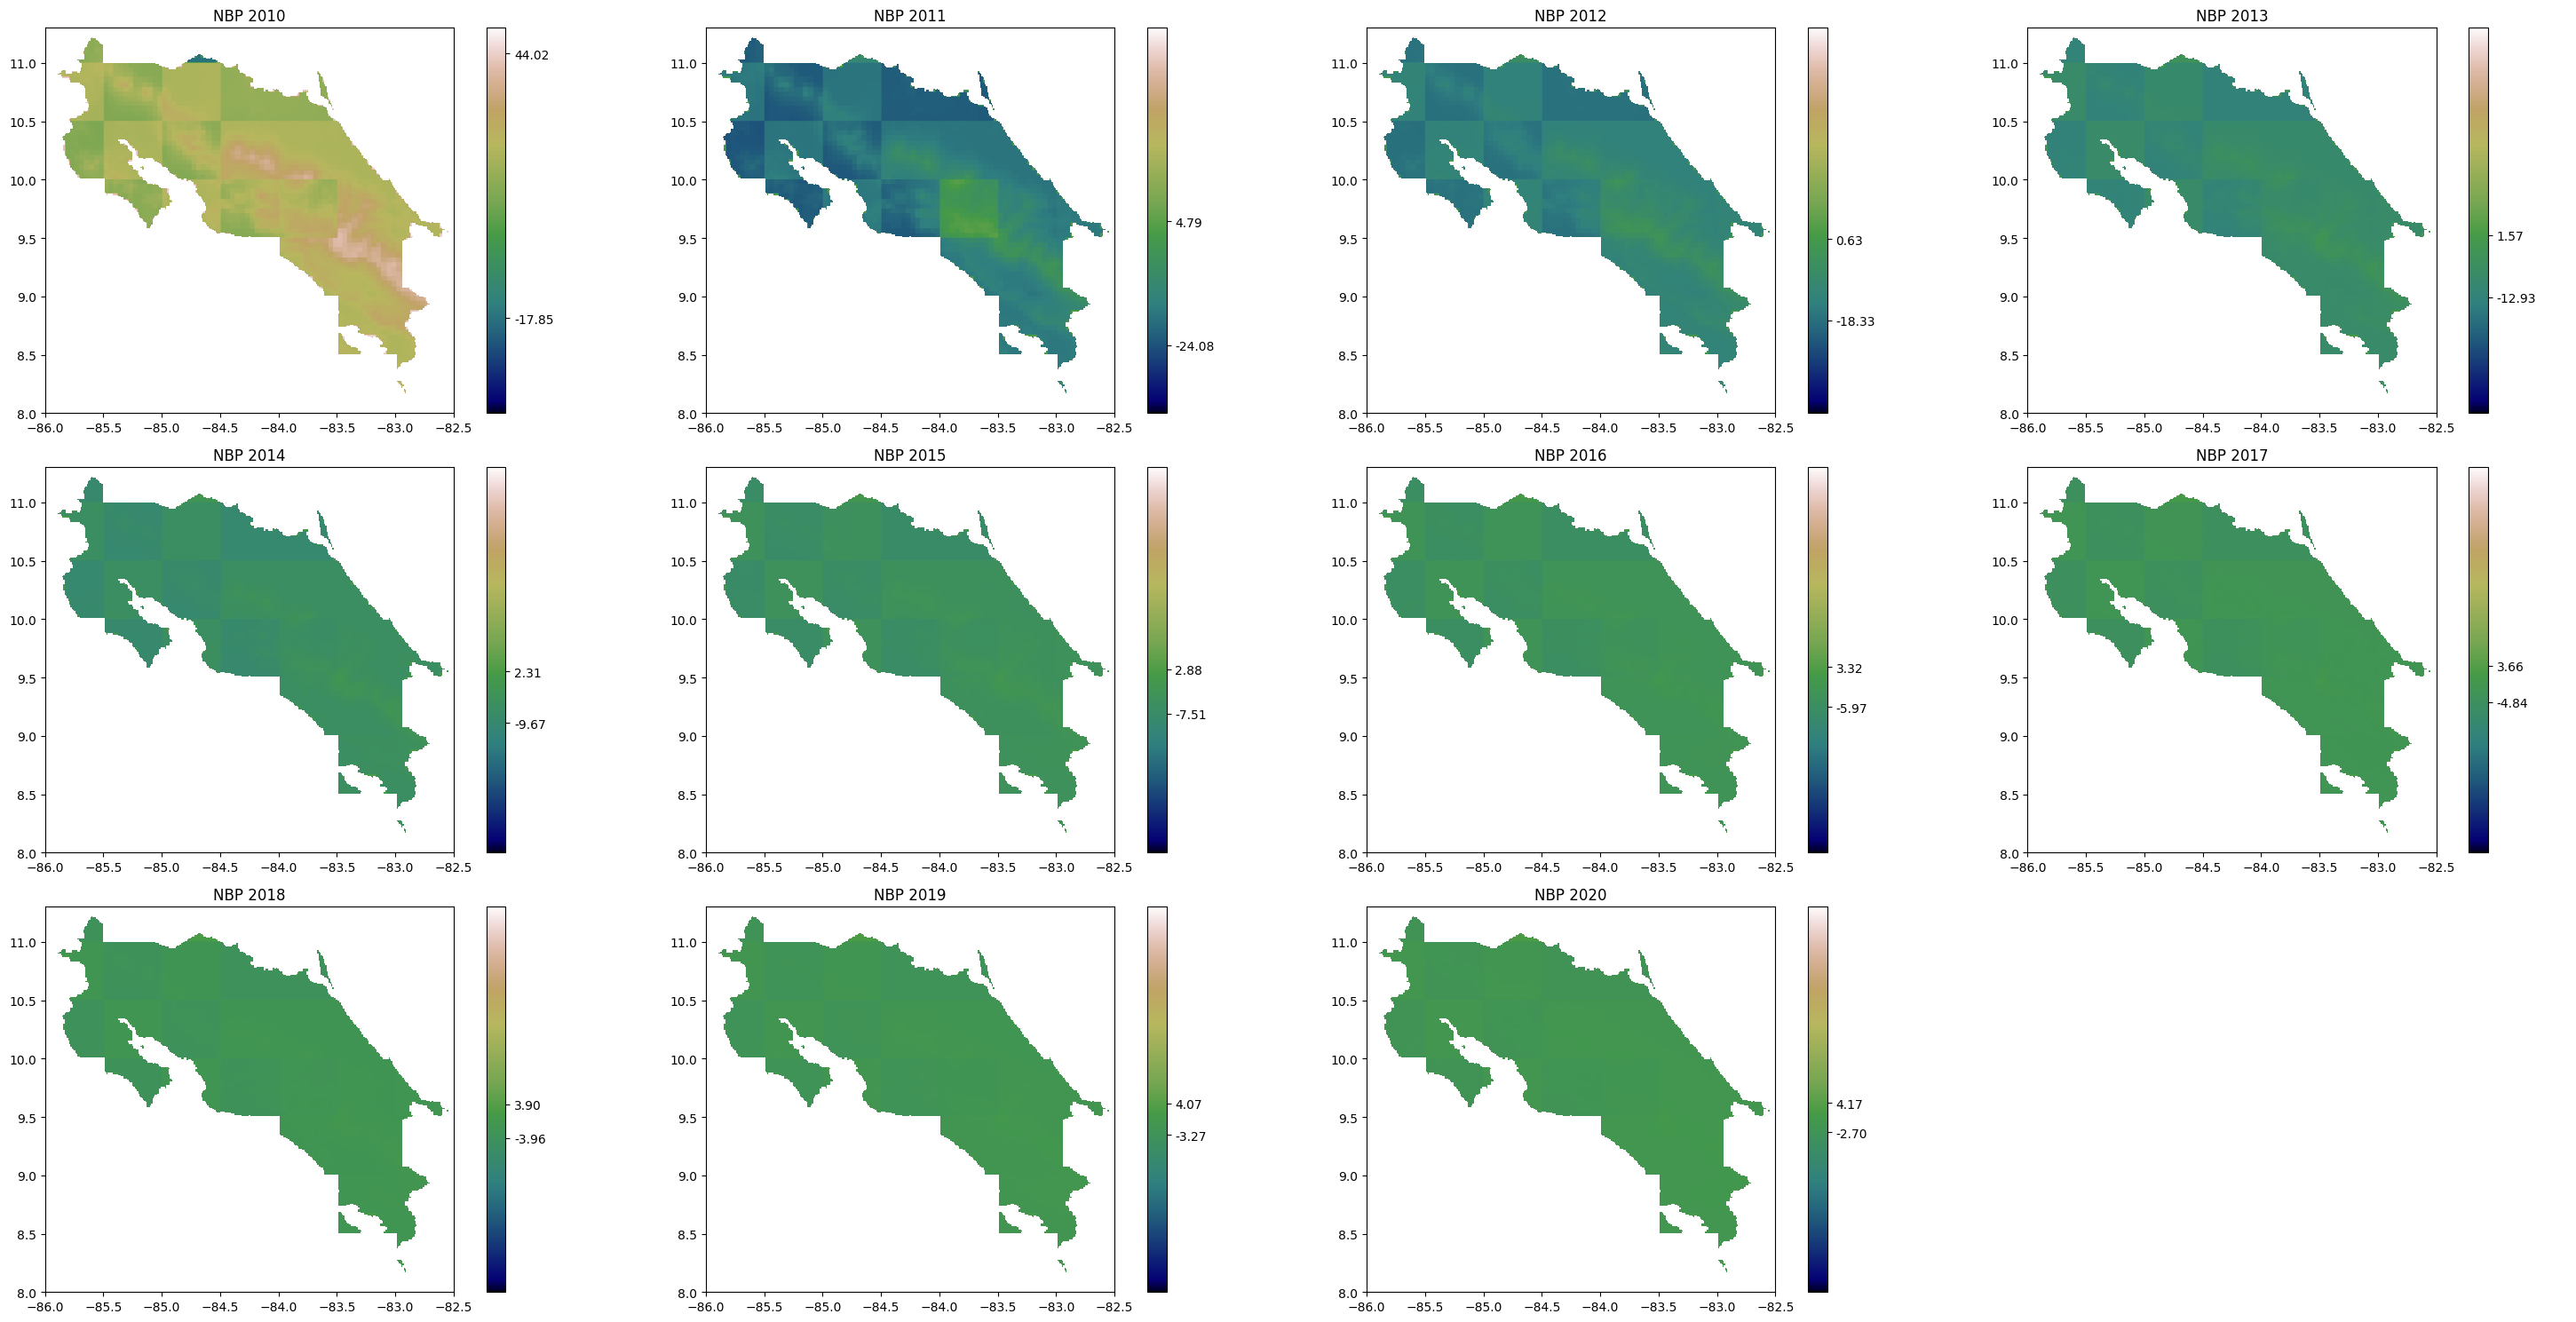

In [ ]:
mpl.rc('image', cmap='gist_earth')

# Base directory containing the files
base_dir = '/content/spatial/'

# Set up the figure and axes for the subplots
fig, axs = plt.subplots(3, 4, figsize=(30, 15))  # 3 rows, 4 columns
axs = axs.flatten()  # Flatten the array of axes for easier iteration

# Define normalization for consistent color scaling across all maps
uniform_norm = colors.Normalize(vmin=-40, vmax=50)

# Loop through each year from 2010 to 2020
for index, year in enumerate(range(2010, 2021)):
    file_path = os.path.join(base_dir, f'NBP_{year}.tif')

    # Open the raster file
    with rasterio.open(file_path) as src:
        # Read the first band
        arr = src.read(1)
        # Replace values below -40 with NaN
        arr = np.where(arr < -40, np.nan, arr)

        # Plotting on specified subplot axis
        ax = axs[index]
        ax.set_title(f'NBP {year}')
        show(arr, transform=src.transform, ax=ax, cmap='gist_earth', norm=uniform_norm)  # Apply uniform normalization here

        # Get the min and max of the current array (ignoring NaN values)
        min_val, max_val = np.nanmin(arr), np.nanmax(arr)

        # Create colorbar with the uniform scale -40 to 50
        mappable = cm.ScalarMappable(norm=uniform_norm, cmap='gist_earth')
        cbar = fig.colorbar(mappable, ax=ax)

        # Set the colorbar to display only the actual min and max values
        cbar.set_ticks([min_val, max_val])
        cbar.set_ticklabels([f'{min_val:.2f}', f'{max_val:.2f}'])

# Hide unused axes
for ax in axs[index + 1:]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
